## Supervised Classifier Models - Hyperparameter Tuning - Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import html
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist, bigrams
from wordcloud import WordCloud
from collections import Counter

In [2]:
df = pd.read_csv('tweets.csv')
df.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


### Distribution of Target Classes:

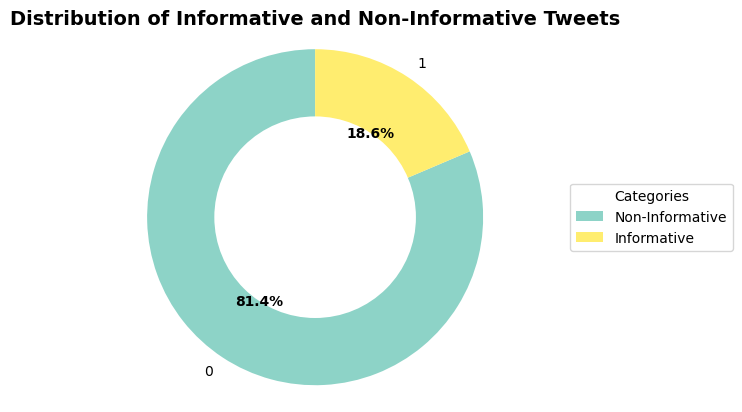

In [3]:
    target_counts = df['target'].value_counts()

    cmap = plt.cm.Set3 

    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90, colors=cmap(np.linspace(0, 1, len(target_counts))))

    centre_circle = plt.Circle((0,0),0.60,fc='white')
    fig.gca().add_artist(centre_circle)

    ax.axis('equal')

    plt.setp(autotexts, size=10, weight="bold")
    plt.setp(texts, size=10)

    legend_labels = ['Non-Informative' if label == 0 else 'Informative' for label in target_counts.index]

    ax.legend(wedges, legend_labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.title('Distribution of Informative and Non-Informative Tweets', fontsize=14, fontweight='bold')

    plt.show()

### Text Length Analysis:

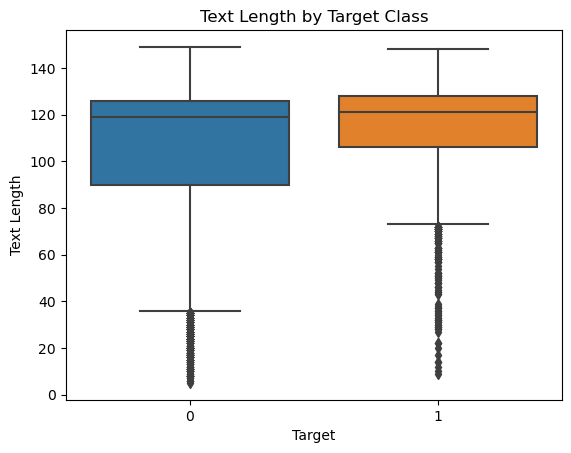

In [4]:
df['text_length'] = df['text'].apply(len)
sns.boxplot(x='target', y='text_length', data=df)
plt.title('Text Length by Target Class')
plt.xlabel('Target')
plt.ylabel('Text Length')
plt.show()

### Word Frequency Analysis:

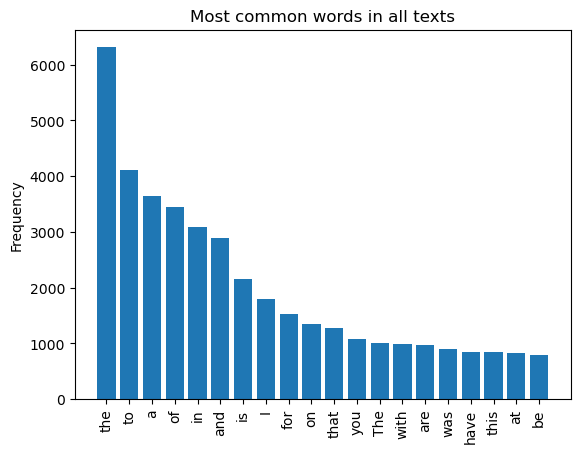

In [5]:
all_words = ' '.join(df['text']).split()
freq_dist = FreqDist(all_words)
most_common_words = freq_dist.most_common(20)
words, counts = zip(*most_common_words)
plt.bar(words, counts)
plt.title('Most common words in all texts')
plt.xticks(rotation='vertical')
plt.ylabel('Frequency')
plt.show()

### Word Cloud for Each Class:

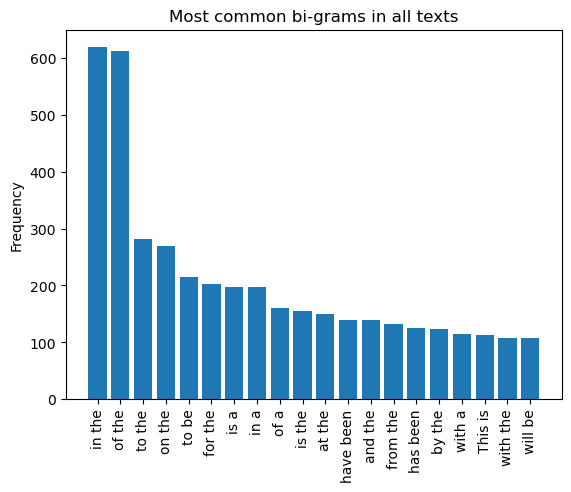

In [6]:
all_bigrams = list(bigrams(all_words))
bigram_freq = FreqDist(all_bigrams)
most_common_bigrams = bigram_freq.most_common(20)
bigram_strings = [' '.join(bigram) for bigram, count in most_common_bigrams]
counts = [count for bigram, count in most_common_bigrams]
plt.bar(bigram_strings, counts)
plt.title('Most common bi-grams in all texts')
plt.xticks(rotation='vertical')
plt.ylabel('Frequency')
plt.show()

### Missing Values

In [7]:
print(f"Number of missing values in 'location': {df['location'].isnull().sum()}")

Number of missing values in 'location': 3418


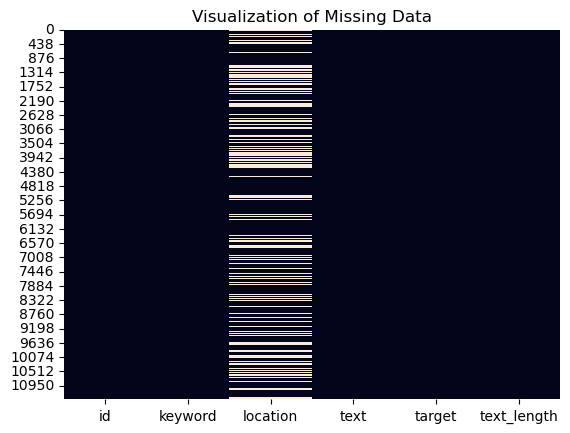

In [8]:
sns.heatmap(df.isnull(), cbar=False)
plt.title('Visualization of Missing Data')
plt.show()

#### Handling missing values by filling with 'Unknown'

In [9]:
df['location'].fillna('Unknown', inplace=True)

### Distribution of Locations:

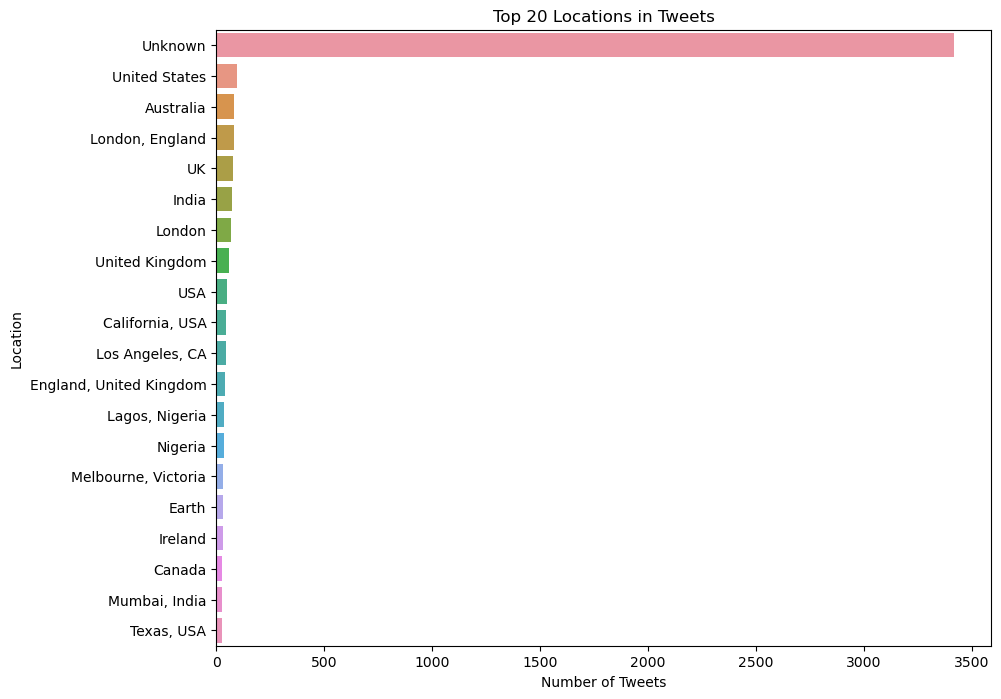

In [10]:
location_counts = df['location'].value_counts()
plt.figure(figsize=(10, 8))
sns.barplot(y=location_counts.index[:20], x=location_counts.values[:20])  # Show top 20 locations
plt.title('Top 20 Locations in Tweets')
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.show()

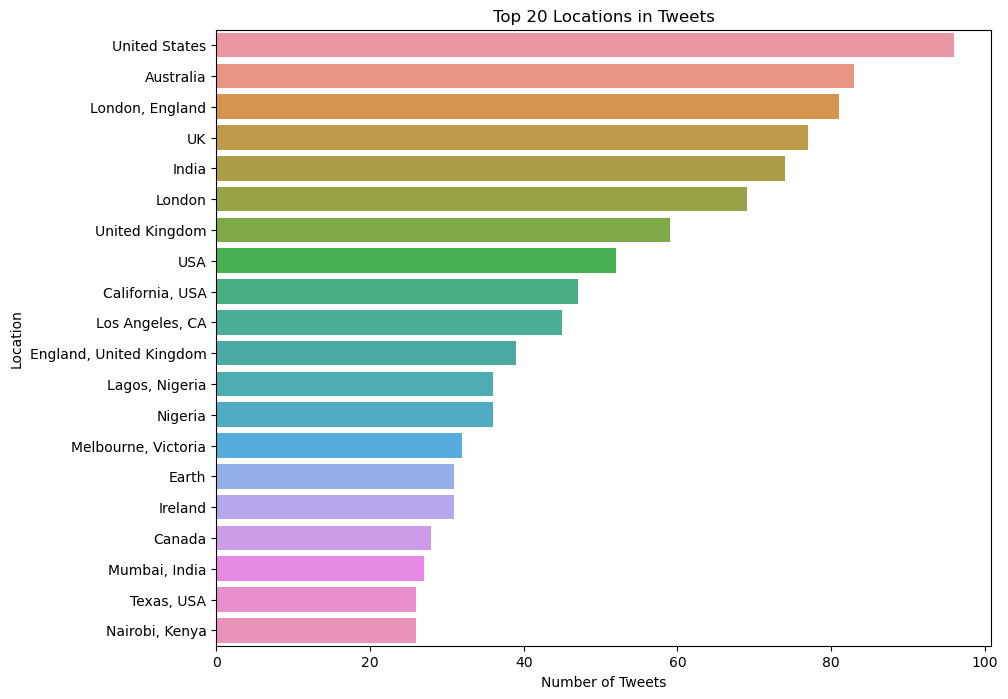

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

location_counts = df['location'].value_counts()

# Remove the 'Unknown' location if it exists
if 'Unknown' in location_counts.index:
    location_counts = location_counts.drop('Unknown')

# Get the top 20 locations
top_20_locations = location_counts[:20]

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(y=top_20_locations.index, x=top_20_locations.values)  # Show top 20 locations
plt.title('Top 20 Locations in Tweets')
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.show()

### Location vs. Target:

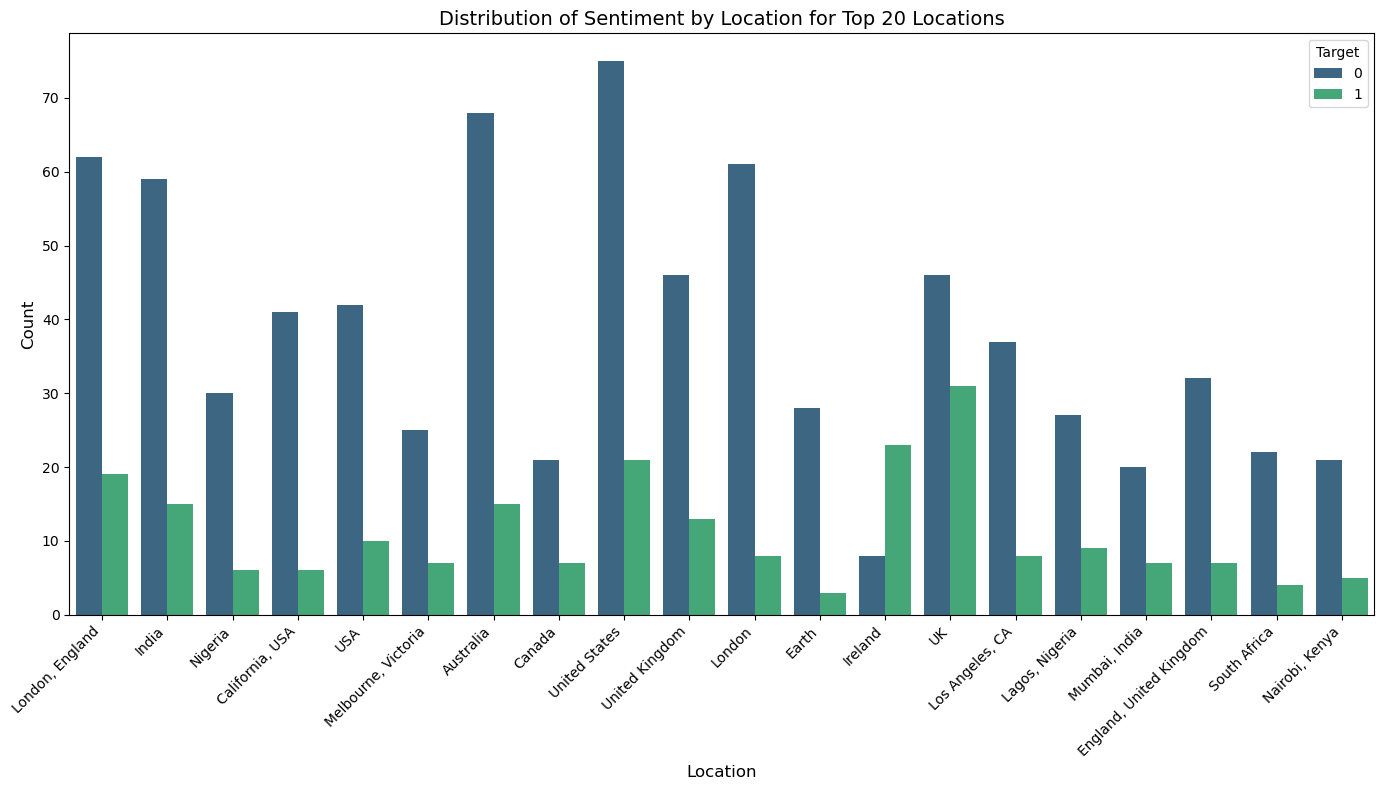

In [12]:
# Filtering to show only top 20 locations by tweet count
top_locations = df[df['location'] != 'Unknown']['location'].value_counts().nlargest(20).index
filtered_df = df[df['location'].isin(top_locations)]

# Creating the plot
plt.figure(figsize=(14, 8))  # Increased figure size
sns.countplot(x='location', hue='target', data=filtered_df, palette='viridis')
plt.title('Distribution of Sentiment by Location for Top 20 Locations', fontsize=14)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels for better fit
plt.legend(title='Target', loc='upper right', fontsize=10)
plt.tight_layout() 
plt.show()


### Proportion of 'Unknown' Locations:

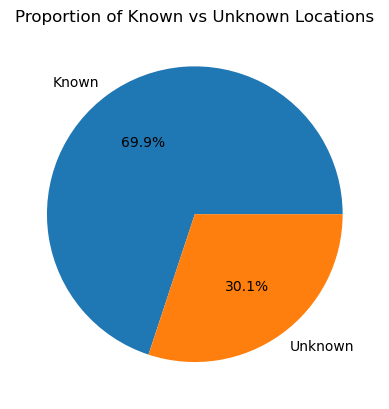

In [13]:
unknown_proportion = (df['location'] == 'Unknown').mean() * 100
known_proportion = 100 - unknown_proportion
plt.pie([known_proportion, unknown_proportion], labels=['Known', 'Unknown'], autopct='%1.1f%%')
plt.title('Proportion of Known vs Unknown Locations')
plt.show()

### Preprocessing

In [14]:
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import html

# Function to remove URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

# Function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Function to remove HTML tags
def remove_html(text):
    html_tag = re.compile(r'<.*?>')
    return html_tag.sub(r'', text)

# Function to remove punctuation (including single and double quotes)
def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation + "“”’‘"))

# Function to remove HTML entities
def remove_html_entities(text):
    return html.unescape(text)

# Function to get POS tags in WordNet format
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Applying preprocessing functions
df['text_clean'] = df['text'].apply(remove_URL)
df['text_clean'] = df['text_clean'].apply(remove_emoji)
df['text_clean'] = df['text_clean'].apply(remove_html)
df['text_clean'] = df['text_clean'].apply(remove_html_entities)
df['text_clean'] = df['text_clean'].apply(remove_punct)

# Tokenizing the clean text
df['tokenized'] = df['text_clean'].apply(word_tokenize)

# Lowercasing the tokenized text
df['lower'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])

# Removing stopwords
stop = set(stopwords.words('english'))
df['stopwords_removed'] = df['lower'].apply(lambda x: [word for word in x if word not in stop])

# Applying part of speech tags
df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)

# Converting parts of speech to WordNet format
df['wordnet_pos'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

# Initialize the WordNet Lemmatizer
wnl = WordNetLemmatizer()

# Applying lemmatization using the WordNet POS tags
df['lemmatized'] = df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x if tag is not None])

# Removing stopwords again from the lemmatized output
df['lemmatized'] = df['lemmatized'].apply(lambda x: [word for word in x if word not in stop])

# Concatenating the lemmatized words into a single string
df['final_text'] = df['lemmatized'].apply(' '.join)

df.head(10)

,id,keyword,location,text,target,text_length,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,final_text
0,0,ablaze,Unknown,"Communal violence in Bhainsa, Telangana. ""Ston...",1,125,Communal violence in Bhainsa Telangana Stones ...,"[Communal, violence, in, Bhainsa, Telangana, S...","[communal, violence, in, bhainsa, telangana, s...","[communal, violence, bhainsa, telangana, stone...","[(communal, JJ), (violence, NN), (bhainsa, NN)...","[(communal, a), (violence, n), (bhainsa, n), (...","[communal, violence, bhainsa, telangana, stone...",communal violence bhainsa telangana stone pelt...
1,1,ablaze,Unknown,Telangana: Section 144 has been imposed in Bha...,1,131,Telangana Section 144 has been imposed in Bhai...,"[Telangana, Section, 144, has, been, imposed, ...","[telangana, section, 144, has, been, imposed, ...","[telangana, section, 144, imposed, bhainsa, ja...","[(telangana, JJ), (section, NN), (144, CD), (i...","[(telangana, a), (section, n), (144, None), (i...","[telangana, section, impose, bhainsa, january,...",telangana section impose bhainsa january clash...
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,63,Arsonist sets cars ablaze at dealership,"[Arsonist, sets, cars, ablaze, at, dealership]","[arsonist, sets, cars, ablaze, at, dealership]","[arsonist, sets, cars, ablaze, dealership]","[(arsonist, JJ), (sets, NNS), (cars, NNS), (ab...","[(arsonist, a), (sets, n), (cars, n), (ablaze,...","[arsonist, set, car, ablaze, dealership]",arsonist set car ablaze dealership
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,87,Arsonist sets cars ablaze at dealership,"[Arsonist, sets, cars, ablaze, at, dealership]","[arsonist, sets, cars, ablaze, at, dealership]","[arsonist, sets, cars, ablaze, dealership]","[(arsonist, JJ), (sets, NNS), (cars, NNS), (ab...","[(arsonist, a), (sets, n), (cars, n), (ablaze,...","[arsonist, set, car, ablaze, dealership]",arsonist set car ablaze dealership
4,4,ablaze,Unknown,"""Lord Jesus, your love brings freedom and pard...",0,140,Lord Jesus your love brings freedom and pardon...,"[Lord, Jesus, your, love, brings, freedom, and...","[lord, jesus, your, love, brings, freedom, and...","[lord, jesus, love, brings, freedom, pardon, f...","[(lord, NN), (jesus, NN), (love, VBP), (brings...","[(lord, n), (jesus, n), (love, v), (brings, n)...","[lord, jesus, love, brings, freedom, pardon, f...",lord jesus love brings freedom pardon fill hol...
5,5,ablaze,OC,"If this child was Chinese, this tweet would ha...",0,122,If this child was Chinese this tweet would hav...,"[If, this, child, was, Chinese, this, tweet, w...","[if, this, child, was, chinese, this, tweet, w...","[child, chinese, tweet, would, gone, viral, so...","[(child, NN), (chinese, JJ), (tweet, NN), (wou...","[(child, n), (chinese, a), (tweet, n), (would,...","[child, chinese, tweet, go, viral, social, med...",child chinese tweet go viral social medium abl...
6,6,ablaze,"London, England",Several houses have been set ablaze in Ngemsib...,1,139,Several houses have been set ablaze in Ngemsib...,"[Several, houses, have, been, set, ablaze, in,...","[several, houses, have, been, set, ablaze, in,...","[several, houses, set, ablaze, ngemsibaa, vill...","[(several, JJ), (houses, NNS), (set, VBD), (ab...","[(several, a), (houses, n), (set, v), (ablaze,...","[several, house, set, ablaze, ngemsibaa, villa...",several house set ablaze ngemsibaa village oku...
7,7,ablaze,Bharat,Asansol: A BJP office in Salanpur village was ...,1,131,Asansol A BJP office in Salanpur village was s...,"[Asansol, A, BJP, office, in, Salanpur, villag...","[asansol, a, bjp, office, in, salanpur, villag...","[asansol, bjp, office, salanpur, village, set,...","[(asansol, NNS), (bjp, JJ), (office, NN), (sal...","[(asansol, n), (bjp, a), (office, n), (salanpu...","[asansol, bjp, office, salanpur, village, set,...",asansol bjp office salanpur village set ablaze...
8,8,ablaze,"Accra, Ghana","National Secu

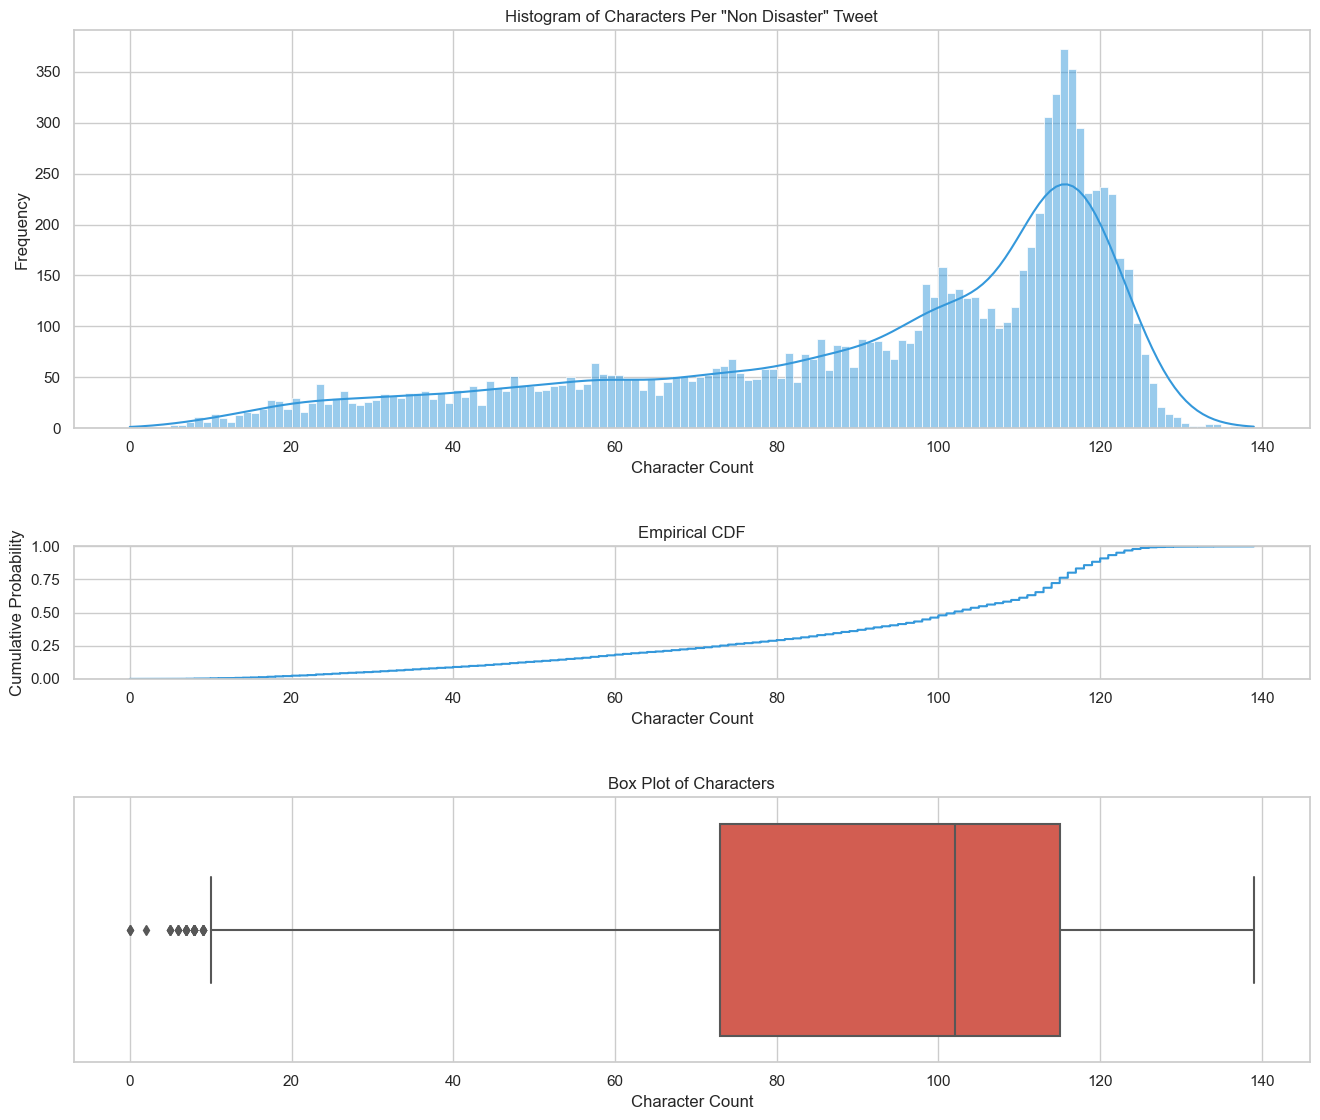

In [15]:
df['Character Count'] = df['text_clean'].apply(lambda x: len(str(x)))

# Selecting non-disaster tweets
non_disaster_tweets = df[df['target'] == 0]

sns.set(style="whitegrid")

fig, axs = plt.subplots(3, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [3, 1, 2]})

# Histogram
sns.histplot(non_disaster_tweets['Character Count'], kde=True, color='#3498db', ax=axs[0], binwidth=1)
axs[0].set_title('Histogram of Characters Per "Non Disaster" Tweet')
axs[0].set_xlabel('Character Count')
axs[0].set_ylabel('Frequency')

# Empirical CDF
sns.ecdfplot(non_disaster_tweets['Character Count'], color='#3498db', ax=axs[1])
axs[1].set_title('Empirical CDF')
axs[1].set_xlabel('Character Count')
axs[1].set_ylabel('Cumulative Probability')

# Box Plot
sns.boxplot(x=non_disaster_tweets['Character Count'], color='#e74c3c', ax=axs[2])
axs[2].set_title('Box Plot of Characters')
axs[2].set_xlabel('Character Count')

plt.tight_layout(pad=3.0)
plt.show()


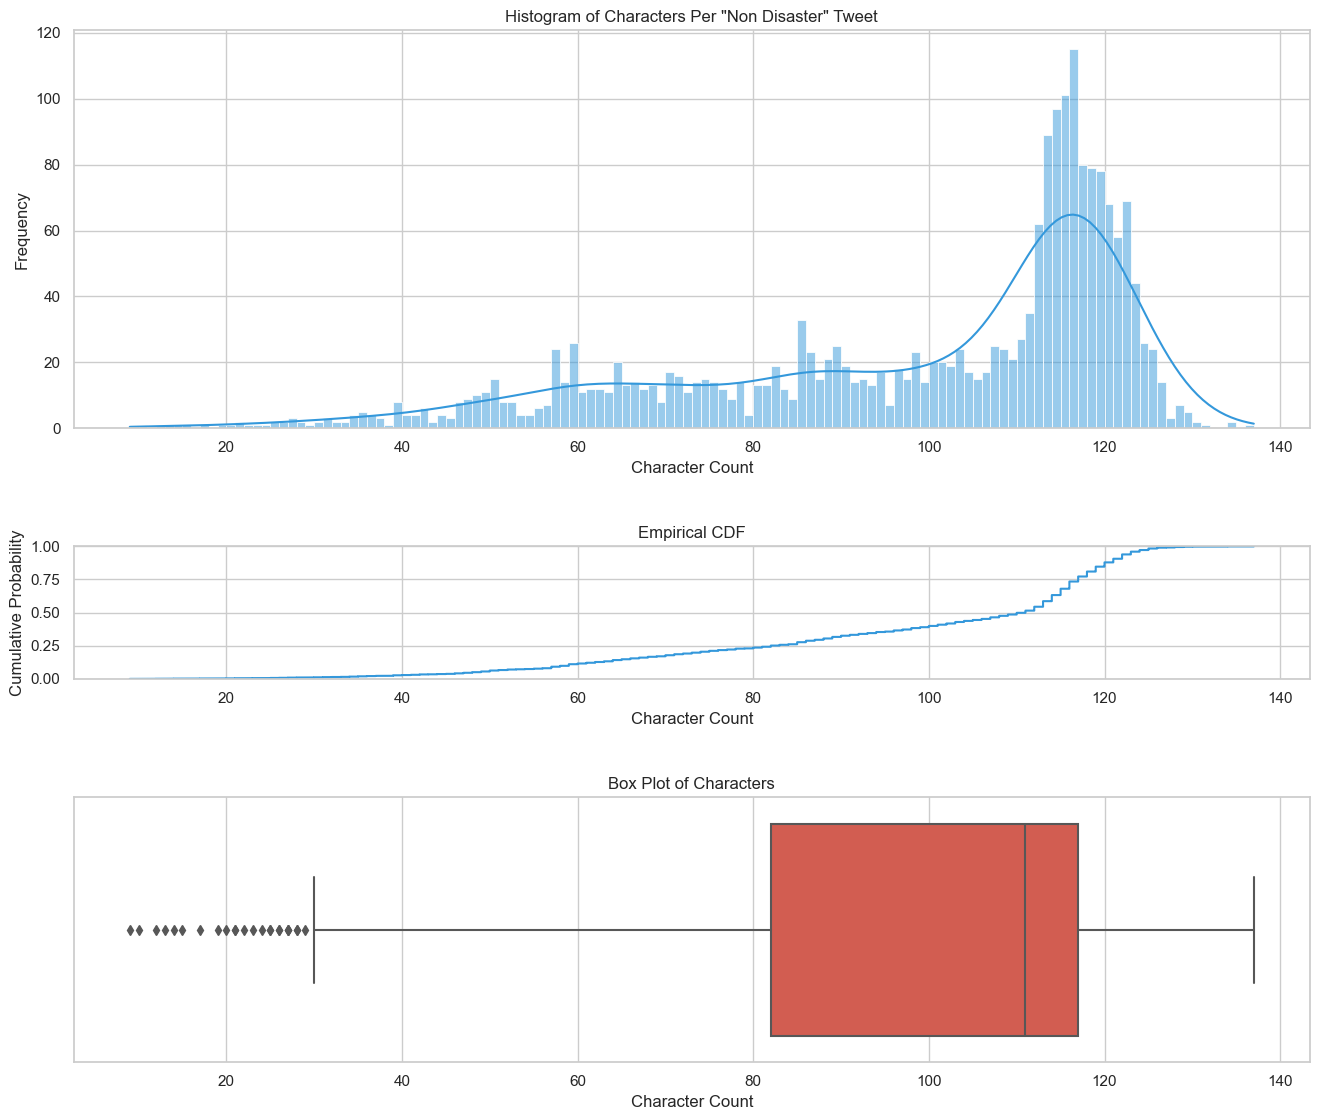

In [16]:
# Selecting disaster tweets
disaster_tweets = df[df['target'] == 1]

# Set style
sns.set(style="whitegrid")

# Create the plot layout
fig, axs = plt.subplots(3, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [3, 1, 2]})

# Histogram
sns.histplot(disaster_tweets['Character Count'], kde=True, color='#3498db', ax=axs[0], binwidth=1)
axs[0].set_title('Histogram of Characters Per "Non Disaster" Tweet')
axs[0].set_xlabel('Character Count')
axs[0].set_ylabel('Frequency')

# Empirical CDF
sns.ecdfplot(disaster_tweets['Character Count'], color='#3498db', ax=axs[1])
axs[1].set_title('Empirical CDF')
axs[1].set_xlabel('Character Count')
axs[1].set_ylabel('Cumulative Probability')

# Box Plot
sns.boxplot(x=disaster_tweets['Character Count'], color='#e74c3c', ax=axs[2])
axs[2].set_title('Box Plot of Characters')
axs[2].set_xlabel('Character Count')

plt.tight_layout(pad=3.0)
plt.show()


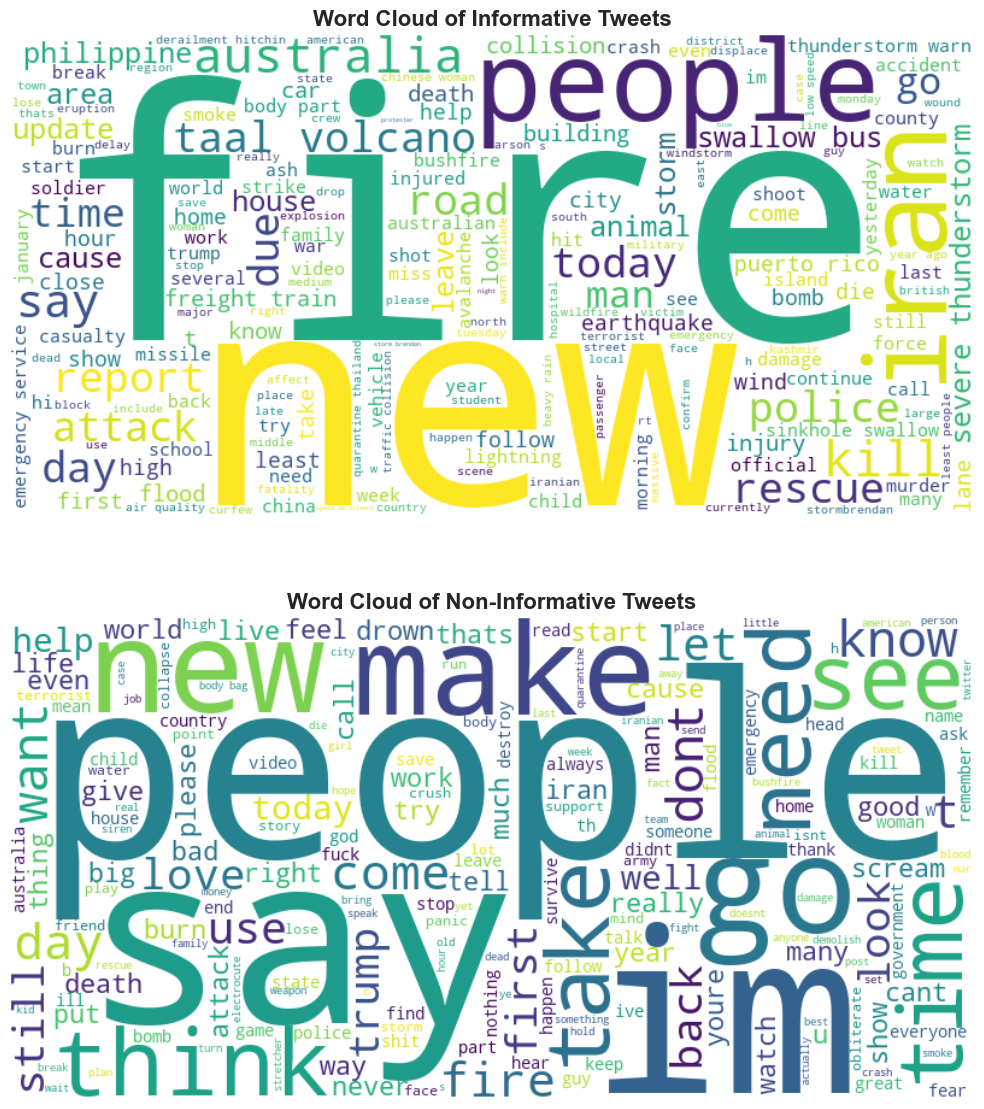

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate informative and non-informative tweets
informative_text = ' '.join(df[df['target'] == 1]['final_text'])
non_informative_text = ' '.join(df[df['target'] == 0]['final_text'])

# Generate word clouds
informative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(informative_text)
non_informative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_informative_text)

# Plot word clouds
plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 1)
plt.imshow(informative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Informative Tweets', fontsize=16, fontweight='bold')

plt.subplot(2, 1, 2)
plt.imshow(non_informative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Non-Informative Tweets', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

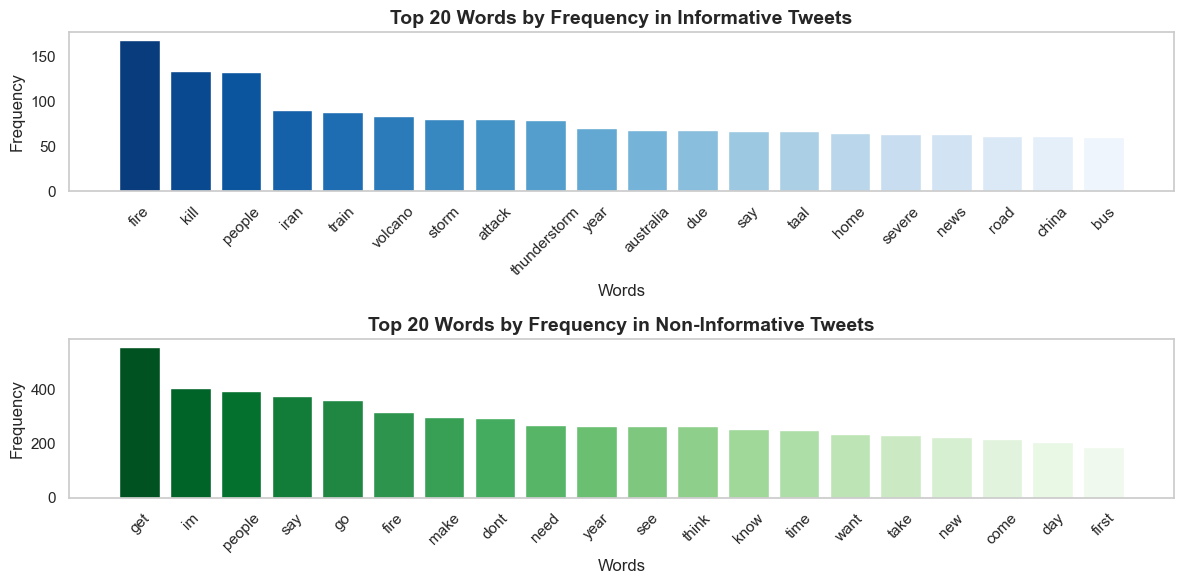

In [18]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Separate informative and non-informative tweets
informative_words = ' '.join(df[df['target'] == 1]['final_text']).split()
non_informative_words = ' '.join(df[df['target'] == 0]['final_text']).split()

# Count word frequencies
informative_freq = Counter(informative_words)
non_informative_freq = Counter(non_informative_words)

# Get the top 20 words
informative_common = informative_freq.most_common(20)
non_informative_common = non_informative_freq.most_common(20)

# Extract words and frequencies
informative_words, informative_freqs = zip(*informative_common)
non_informative_words, non_informative_freqs = zip(*non_informative_common)

# Define pastel color palette
colors_informative = list(reversed(sns.color_palette("Blues", len(informative_words))))
colors_non_informative = list(reversed(sns.color_palette("Greens", len(non_informative_words))))

# Plotting informative tweets
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.bar(informative_words, informative_freqs, color=colors_informative)
plt.title('Top 20 Words by Frequency in Informative Tweets', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.grid(False)

# Plotting non-informative tweets
plt.subplot(2, 1, 2)
plt.bar(non_informative_words, non_informative_freqs, color=colors_non_informative)
plt.title('Top 20 Words by Frequency in Non-Informative Tweets', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.grid(False)

plt.tight_layout()
plt.show()

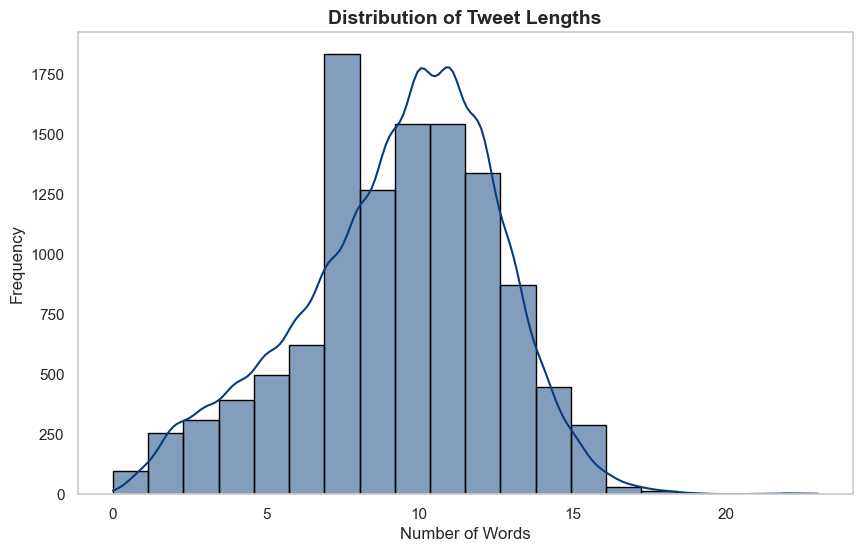

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

tweet_lengths = df['final_text'].apply(lambda x: len(x.split()))


color = sns.color_palette("Blues", 20)[-1]  # Choose a darker blue

plt.figure(figsize=(10, 6))
sns.histplot(tweet_lengths, bins=20, kde=True, color=color, edgecolor='black')

plt.grid(False)

plt.title('Distribution of Tweet Lengths', fontsize=14, fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.show()

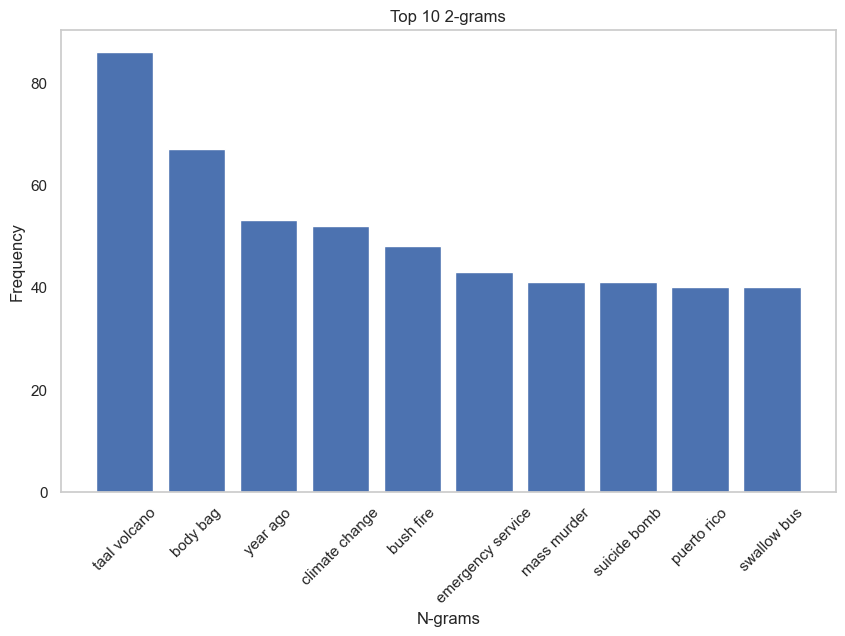

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

def plot_ngrams(text_data, n=2, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngram_counts = vectorizer.fit_transform(text_data)
    ngram_freq = ngram_counts.sum(axis=0).A1
    ngram_freq_dict = dict(zip(vectorizer.get_feature_names_out(), ngram_freq))
    sorted_ngrams = sorted(ngram_freq_dict.items(), key=lambda x: x[1], reverse=True)[:top_k]
    
    ngrams, freqs = zip(*sorted_ngrams)
    plt.figure(figsize=(10, 6))
    plt.bar(ngrams, freqs)
    plt.grid(False)
    plt.title(f'Top {top_k} {n}-grams')
    plt.xticks(rotation=45)
    plt.xlabel('N-grams')
    plt.ylabel('Frequency')
    plt.show()   
    
# Plot bigrams

plot_ngrams(df['final_text'], n=2)

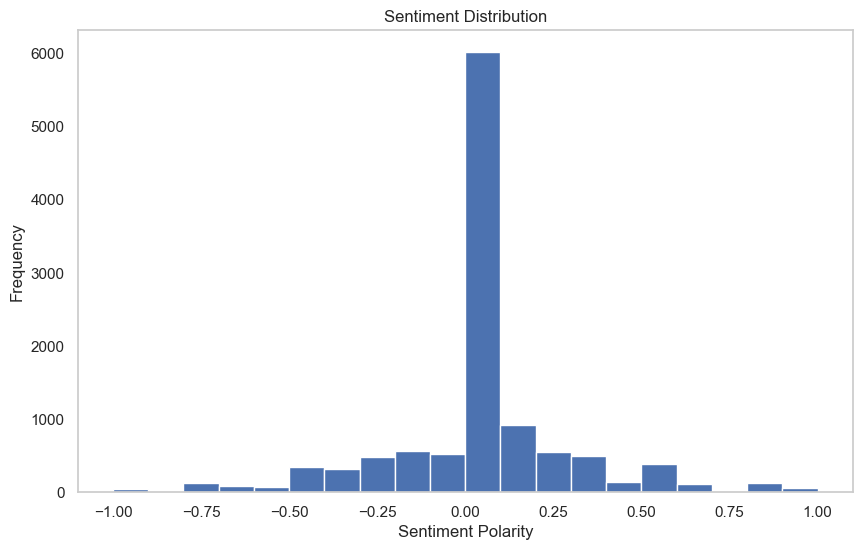

In [21]:
from textblob import TextBlob

df['sentiment'] = df['final_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
plt.figure(figsize=(10, 6))
plt.hist(df['sentiment'], bins=20)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

### Vectorisation

#### Bag of Words, TF-IDF and BERT

In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
import numpy as np
import torch
from transformers import BertTokenizer, BertModel


# 1. TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
tfidf_matrix = tfidf_vectorizer.fit_transform(df['final_text'])

# 2. Count Vectorisation
count_vectorizer = CountVectorizer(max_features=1000)  # Adjust max_features as needed
count_matrix = count_vectorizer.fit_transform(df['final_text'])

# 3. Word Embeddings (Word2Vec)
# Tokenize the sentences for Word2Vec
tokenized_sentences = df['final_text'].apply(lambda x: x.split())

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Get the embeddings for each document (average of word embeddings)
def get_document_embedding(doc):
    words = doc.split()
    word_embeddings = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

df['word2vec_embedding'] = df['final_text'].apply(get_document_embedding)

# 4. Transformer-based Embeddings (BERT)
# Initialize BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

df['bert_embedding'] = df['final_text'].apply(get_bert_embedding)



In [23]:
print("TF-IDF Matrix shape:", tfidf_matrix.shape)
print("Count Matrix shape:", count_matrix.shape)
print("Word2Vec Embedding shape:", df['word2vec_embedding'].iloc[0].shape)
print("BERT Embedding shape:", df['bert_embedding'].iloc[0].shape)

TF-IDF Matrix shape: (11370, 1000)
Count Matrix shape: (11370, 1000)
Word2Vec Embedding shape: (100,)
BERT Embedding shape: (768,)


### Split Test and Train

In [24]:
from sklearn.model_selection import train_test_split

# Define the target variable
y = df['target']

# Split the datasets
# 1. TF-IDF
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

# 2. Count Vectorization
X_count_train, X_count_test, y_count_train, y_count_test = train_test_split(count_matrix, y, test_size=0.2, random_state=42)

# 3. Word2Vec Embeddings
X_word2vec = np.stack(df['word2vec_embedding'].values)
X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

# 4. BERT Embeddings
X_bert = np.stack(df['bert_embedding'].values)
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)

### Model

### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Initialize a dictionary to store metrics for each model
lr_metrics = {
    "Model": [],
    "Vectorization": [],
    "Accuracy": [],
    "F1 Score": [],
    "Precision": [],
    "Recall": []
}

# Function to train and evaluate the model
def train_and_evaluate(X_train, X_test, y_train, y_test, model_name):
    # Initialize the Logistic Regression model
    model = LogisticRegression(max_iter=1000)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate and store the metrics
    lr_metrics["Model"].append('Logistic Regression')
    lr_metrics["Vectorization"].append(model_name)
    lr_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    lr_metrics["F1 Score"].append(f1_score(y_test, y_pred, average='macro'))
    lr_metrics["Precision"].append(precision_score(y_test, y_pred, average='macro'))
    lr_metrics["Recall"].append(recall_score(y_test, y_pred, average='macro'))
    
    # Print the classification report
    print(f"Logistic Regression ({model_name}) Classification Report:")
    print(classification_report(y_test, y_pred))

# Train and evaluate models for each text representation

# 1. TF-IDF
train_and_evaluate(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test, "TF-IDF")

# 2. Count Vectorization
train_and_evaluate(X_count_train, X_count_test, y_count_train, y_count_test, "Count Vectorization")

# 3. Word2Vec
train_and_evaluate(X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test, "Word2Vec")

# 4. BERT
train_and_evaluate(X_bert_train, X_bert_test, y_bert_train, y_bert_test, "BERT")

# Convert the metrics dictionary to a DataFrame for better visualization
lr_metrics_df = pd.DataFrame(lr_metrics)

# Display the DataFrame
print(lr_metrics_df)

Logistic Regression (TF-IDF) Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1878
           1       0.83      0.42      0.56       396

    accuracy                           0.88      2274
   macro avg       0.86      0.70      0.74      2274
weighted avg       0.88      0.88      0.87      2274

Logistic Regression (Count Vectorization) Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1878
           1       0.73      0.53      0.61       396

    accuracy                           0.88      2274
   macro avg       0.82      0.74      0.77      2274
weighted avg       0.88      0.88      0.88      2274

Logistic Regression (Word2Vec) Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      1878
           1       0.00      0.00      0.00       396

    accurac

C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Logistic Regression (BERT) Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1878
           1       0.71      0.60      0.65       396

    accuracy                           0.89      2274
   macro avg       0.81      0.77      0.79      2274
weighted avg       0.88      0.89      0.88      2274

                 Model        Vectorization  Accuracy  F1 Score  Precision  \
0  Logistic Regression               TF-IDF  0.883905  0.744394   0.861031   
1  Logistic Regression  Count Vectorization  0.884345  0.772345   0.820279   
2  Logistic Regression             Word2Vec  0.825858  0.452312   0.412929   
3  Logistic Regression                 BERT  0.887863  0.792178   0.814481   

     Recall  
0  0.699547  
1  0.742658  
2  0.500000  
3  0.774680  


### SVM

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Initialize a dictionary to store metrics for each model
svm_metrics = {
    "Model": [],
    "Vectorization": [],
    "Accuracy": [],
    "F1 Score": [],
    "Precision": [],
    "Recall": []
}

# Function to train and evaluate the SVM model
def train_and_evaluate_svm(X_train, X_test, y_train, y_test, model_name):
    # Initialize the SVM model (with default settings)
    model = SVC(max_iter=1000)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate and store the metrics
    svm_metrics["Model"].append('SVM')
    svm_metrics["Vectorization"].append(model_name)
    svm_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    svm_metrics["F1 Score"].append(f1_score(y_test, y_pred, average='macro'))
    svm_metrics["Precision"].append(precision_score(y_test, y_pred, average='macro'))
    svm_metrics["Recall"].append(recall_score(y_test, y_pred, average='macro'))
    
    # Print the classification report
    print(f"SVM ({model_name}) Classification Report:")
    print(classification_report(y_test, y_pred))

# Train and evaluate models for each text representation

# 1. TF-IDF
train_and_evaluate_svm(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test, "TF-IDF")

# 2. Count Vectorization
train_and_evaluate_svm(X_count_train, X_count_test, y_count_train, y_count_test, "Count Vectorization")

# 3. Word2Vec
train_and_evaluate_svm(X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test, "Word2Vec")

# 4. BERT
train_and_evaluate_svm(X_bert_train, X_bert_test, y_bert_train, y_bert_test, "BERT")

# Convert the metrics dictionary to a DataFrame for better visualization
svm_metrics_df = pd.DataFrame(svm_metrics)

# Display the DataFrame
print(svm_metrics_df)

C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM (TF-IDF) Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1878
           1       0.73      0.59      0.65       396

    accuracy                           0.89      2274
   macro avg       0.82      0.77      0.79      2274
weighted avg       0.88      0.89      0.89      2274



C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM (Count Vectorization) Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1878
           1       0.75      0.57      0.65       396

    accuracy                           0.89      2274
   macro avg       0.83      0.76      0.79      2274
weighted avg       0.89      0.89      0.89      2274



C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM (Word2Vec) Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.10      0.17      1878
           1       0.18      0.93      0.30       396

    accuracy                           0.24      2274
   macro avg       0.53      0.52      0.24      2274
weighted avg       0.75      0.24      0.20      2274



C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM (BERT) Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1878
           1       0.58      0.72      0.64       396

    accuracy                           0.86      2274
   macro avg       0.76      0.80      0.78      2274
weighted avg       0.88      0.86      0.87      2274

  Model        Vectorization  Accuracy  F1 Score  Precision    Recall
0   SVM               TF-IDF  0.890501  0.792922   0.824030  0.770299
1   SVM  Count Vectorization  0.892260  0.791948   0.832963  0.764389
2   SVM             Word2Vec  0.242744  0.237533   0.527045  0.515628
3   SVM                 BERT  0.859719  0.776994   0.757884  0.804470


### Random Forests

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Initialize a dictionary to store metrics for each model
rf_metrics = {
    "Model": [],
    "Vectorization": [],
    "Accuracy": [],
    "F1 Score": [],
    "Precision": [],
    "Recall": []
}

# Function to train and evaluate the Random Forest model
def train_and_evaluate_rf(X_train, X_test, y_train, y_test, model_name):
    # Initialize the Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate and store the metrics
    rf_metrics["Model"].append('Random Forest')
    rf_metrics["Vectorization"].append(model_name)
    rf_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    rf_metrics["F1 Score"].append(f1_score(y_test, y_pred, average='macro'))
    rf_metrics["Precision"].append(precision_score(y_test, y_pred, average='macro'))
    rf_metrics["Recall"].append(recall_score(y_test, y_pred, average='macro'))
    
    # Print the classification report
    print(f"Random Forest ({model_name}) Classification Report:")
    print(classification_report(y_test, y_pred))

# Train and evaluate models for each text representation

# 1. TF-IDF
train_and_evaluate_rf(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test, "TF-IDF")

# 2. Count Vectorization
train_and_evaluate_rf(X_count_train, X_count_test, y_count_train, y_count_test, "Count Vectorization")

# 3. Word2Vec
train_and_evaluate_rf(X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test, "Word2Vec")

# 4. BERT
train_and_evaluate_rf(X_bert_train, X_bert_test, y_bert_train, y_bert_test, "BERT")

# Convert the metrics dictionary to a DataFrame for better visualization
rf_metrics_df = pd.DataFrame(rf_metrics)

# Display the DataFrame
print(rf_metrics_df)

Random Forest (TF-IDF) Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1878
           1       0.77      0.49      0.60       396

    accuracy                           0.89      2274
   macro avg       0.83      0.73      0.76      2274
weighted avg       0.88      0.89      0.87      2274

Random Forest (Count Vectorization) Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1878
           1       0.70      0.52      0.60       396

    accuracy                           0.88      2274
   macro avg       0.80      0.74      0.76      2274
weighted avg       0.87      0.88      0.87      2274

Random Forest (Word2Vec) Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1878
           1       0.85      0.20      0.33       396

    accuracy                 

### XGBoost

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Initialize a dictionary to store metrics for each model
xgb_metrics = {
    "Model": [],
    "Vectorization": [],
    "Accuracy": [],
    "F1 Score": [],
    "Precision": [],
    "Recall": []
}

# Function to train and evaluate the XGBoost model
def train_and_evaluate_xgb(X_train, X_test, y_train, y_test, model_name):
    # Initialize the XGBoost model
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate and store the metrics
    xgb_metrics["Model"].append('XGBoost')
    xgb_metrics["Vectorization"].append(model_name)
    xgb_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    xgb_metrics["F1 Score"].append(f1_score(y_test, y_pred, average='macro'))
    xgb_metrics["Precision"].append(precision_score(y_test, y_pred, average='macro'))
    xgb_metrics["Recall"].append(recall_score(y_test, y_pred, average='macro'))
    
    # Print the classification report
    print(f"XGBoost ({model_name}) Classification Report:")
    print(classification_report(y_test, y_pred))

# Train and evaluate models for each text representation

# 1. TF-IDF
train_and_evaluate_xgb(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test, "TF-IDF")

# 2. Count Vectorization
train_and_evaluate_xgb(X_count_train, X_count_test, y_count_train, y_count_test, "Count Vectorization")

# 3. Word2Vec
train_and_evaluate_xgb(X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test, "Word2Vec")

# 4. BERT
train_and_evaluate_xgb(X_bert_train, X_bert_test, y_bert_train, y_bert_test, "BERT")

# Convert the metrics dictionary to a DataFrame for better visualization
xgb_metrics_df = pd.DataFrame(xgb_metrics)

# Display the DataFrame
print(xgb_metrics_df)

XGBoost (TF-IDF) Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1878
           1       0.83      0.43      0.56       396

    accuracy                           0.88      2274
   macro avg       0.86      0.71      0.75      2274
weighted avg       0.88      0.88      0.87      2274

XGBoost (Count Vectorization) Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1878
           1       0.81      0.43      0.56       396

    accuracy                           0.88      2274
   macro avg       0.85      0.70      0.75      2274
weighted avg       0.88      0.88      0.87      2274

XGBoost (Word2Vec) Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1878
           1       0.65      0.28      0.39       396

    accuracy                           0.85    

### AdaBoost

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Initialize a dictionary to store metrics for each model
ada_metrics = {
    "Model": [],
    "Vectorization": [],
    "Accuracy": [],
    "F1 Score": [],
    "Precision": [],
    "Recall": []
}

# Function to train and evaluate the AdaBoost model
def train_and_evaluate_ada(X_train, X_test, y_train, y_test, model_name):
    # Initialize the AdaBoost model
    model = AdaBoostClassifier(n_estimators=100, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate and store the metrics
    ada_metrics["Model"].append('AdaBoost')
    ada_metrics["Vectorization"].append(model_name)
    ada_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    ada_metrics["F1 Score"].append(f1_score(y_test, y_pred, average='macro'))
    ada_metrics["Precision"].append(precision_score(y_test, y_pred, average='macro'))
    ada_metrics["Recall"].append(recall_score(y_test, y_pred, average='macro'))
    
    # Print the classification report
    print(f"AdaBoost ({model_name}) Classification Report:")
    print(classification_report(y_test, y_pred))

# Train and evaluate models for each text representation

# 1. TF-IDF
train_and_evaluate_ada(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test, "TF-IDF")

# 2. Count Vectorization
train_and_evaluate_ada(X_count_train, X_count_test, y_count_train, y_count_test, "Count Vectorization")

# 3. Word2Vec
train_and_evaluate_ada(X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test, "Word2Vec")

# 4. BERT
train_and_evaluate_ada(X_bert_train, X_bert_test, y_bert_train, y_bert_test, "BERT")

# Convert the metrics dictionary to a DataFrame for better visualization
ada_metrics_df = pd.DataFrame(ada_metrics)

# Display the DataFrame
print(ada_metrics_df)

C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost (TF-IDF) Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1878
           1       0.67      0.43      0.53       396

    accuracy                           0.86      2274
   macro avg       0.78      0.69      0.72      2274
weighted avg       0.85      0.86      0.85      2274



C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost (Count Vectorization) Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1878
           1       0.69      0.42      0.52       396

    accuracy                           0.87      2274
   macro avg       0.79      0.69      0.72      2274
weighted avg       0.85      0.87      0.85      2274



C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost (Word2Vec) Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1878
           1       0.52      0.12      0.20       396

    accuracy                           0.83      2274
   macro avg       0.68      0.55      0.55      2274
weighted avg       0.78      0.83      0.78      2274



C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost (BERT) Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1878
           1       0.61      0.54      0.57       396

    accuracy                           0.86      2274
   macro avg       0.76      0.73      0.74      2274
weighted avg       0.85      0.86      0.86      2274

      Model        Vectorization  Accuracy  F1 Score  Precision    Recall
0  AdaBoost               TF-IDF  0.864116  0.723027   0.779573  0.693545
1  AdaBoost  Count Vectorization  0.865875  0.723058   0.786672  0.691621
2  AdaBoost             Word2Vec  0.827177  0.551362   0.678271  0.549622
3  AdaBoost                 BERT  0.859719  0.743411   0.757733  0.731734


### LightGBM

In [30]:
import lightgbm as lgb
from sklearn.metrics import classification_report

lgb_metrics = {
    "Model": [],
    "Vectorization": [],
    "Accuracy": [],
    "F1 Score": [],
    "Precision": [],
    "Recall": []
}

# Convert data to float32
X_tfidf_train = X_tfidf_train.astype('float32')
X_tfidf_test = X_tfidf_test.astype('float32')
X_count_train = X_count_train.astype('float32')
X_count_test = X_count_test.astype('float32')
X_word2vec_train = X_word2vec_train.astype('float32')
X_word2vec_test = X_word2vec_test.astype('float32')
X_bert_train = X_bert_train.astype('float32')
X_bert_test = X_bert_test.astype('float32')

# Function to train and evaluate the LightGBM model
def train_and_evaluate_lgb(X_train, X_test, y_train, y_test, model_name):
    # Initialize the LightGBM model
    model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate and store the metrics
    lgb_metrics["Model"].append('LightGBM')
    lgb_metrics["Vectorization"].append(model_name)
    lgb_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    lgb_metrics["F1 Score"].append(f1_score(y_test, y_pred, average='macro'))
    lgb_metrics["Precision"].append(precision_score(y_test, y_pred, average='macro'))
    lgb_metrics["Recall"].append(recall_score(y_test, y_pred, average='macro'))
    
    # Print the classification report
    print(f"LightGBM ({model_name}) Classification Report:")
    print(classification_report(y_test, y_pred))

# Train and evaluate models for each text representation

# 1. TF-IDF
train_and_evaluate_lgb(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test, "TF-IDF")

# 2. Count Vectorization
train_and_evaluate_lgb(X_count_train, X_count_test, y_count_train, y_count_test, "Count Vectorization")

# 3. Word2Vec
train_and_evaluate_lgb(X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test, "Word2Vec")

# 4. BERT
train_and_evaluate_lgb(X_bert_train, X_bert_test, y_bert_train, y_bert_test, "BERT")

# Convert the metrics dictionary to a DataFrame for better visualization
lgb_metrics_df = pd.DataFrame(lgb_metrics)

# Display the DataFrame
print(lgb_metrics_df)

[LightGBM] [Info] Number of positive: 1718, number of negative: 7378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14764
[LightGBM] [Info] Number of data points in the train set: 9096, number of used features: 821
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.188874 -> initscore=-1.457342
[LightGBM] [Info] Start training from score -1.457342
LightGBM (TF-IDF) Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      1878
           1       0.80      0.49      0.61       396

    accuracy                           0.89      2274
   macro avg       0.85      0.73      0.77      2274
weighted avg       0.88      0.89      0.88      2274

[LightGBM] [Info] Number of positive: 1718, number of negative: 7378
[Light

### Naive Bayes

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Initialize a dictionary to store metrics for each model
nb_metrics = {
    "Model": [],
    "Vectorization": [],
    "Accuracy": [],
    "F1 Score": [],
    "Precision": [],
    "Recall": []
}

# Function to train and evaluate the Naive Bayes model
def train_and_evaluate_nb(X_train, X_test, y_train, y_test, model_name):
    # Initialize the Naive Bayes model
    model = MultinomialNB()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate and store the metrics
    nb_metrics["Model"].append('Naive Bayes')
    nb_metrics["Vectorization"].append(model_name)
    nb_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    nb_metrics["F1 Score"].append(f1_score(y_test, y_pred, average='macro'))
    nb_metrics["Precision"].append(precision_score(y_test, y_pred, average='macro'))
    nb_metrics["Recall"].append(recall_score(y_test, y_pred, average='macro'))
    
    # Print the classification report
    print(f"Naive Bayes ({model_name}) Classification Report:")
    print(classification_report(y_test, y_pred))

# Train and evaluate models for each suitable text representation

# 1. TF-IDF
train_and_evaluate_nb(X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test, "TF-IDF")

# 2. Count Vectorization
train_and_evaluate_nb(X_count_train, X_count_test, y_count_train, y_count_test, "Count Vectorization")

# Convert the metrics dictionary to a DataFrame for better visualization
nb_metrics_df = pd.DataFrame(nb_metrics)

# Display the DataFrame
print(nb_metrics_df)

Naive Bayes (TF-IDF) Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1878
           1       0.82      0.41      0.55       396

    accuracy                           0.88      2274
   macro avg       0.85      0.69      0.74      2274
weighted avg       0.88      0.88      0.86      2274

Naive Bayes (Count Vectorization) Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1878
           1       0.65      0.64      0.64       396

    accuracy                           0.88      2274
   macro avg       0.79      0.78      0.79      2274
weighted avg       0.88      0.88      0.88      2274

         Model        Vectorization  Accuracy  F1 Score  Precision    Recall
0  Naive Bayes               TF-IDF  0.881266  0.738585   0.852733  0.694961
1  Naive Bayes  Count Vectorization  0.877309  0.785222   0.787262  0.783236


### Evaluation

In [32]:
import pandas as pd

# Assuming you have the individual metrics DataFrames as described
# Example DataFrames: lr_metrics_df, svm_metrics_df, rf_metrics_df, xgb_metrics_df, ada_metrics_df, lgb_metrics_df, nb_metrics_df

# Combine all the metrics DataFrames into one
results_df = pd.concat([lr_metrics_df, svm_metrics_df, rf_metrics_df, xgb_metrics_df, ada_metrics_df, lgb_metrics_df, nb_metrics_df], ignore_index=True)

# Rearrange columns to match the desired format
results_df = results_df[['Model', 'Vectorization', 'Accuracy', 'F1 Score', 'Precision', 'Recall']]

# Display the combined results DataFrame
print(results_df)

                  Model        Vectorization  Accuracy  F1 Score  Precision  \
0   Logistic Regression               TF-IDF  0.883905  0.744394   0.861031   
1   Logistic Regression  Count Vectorization  0.884345  0.772345   0.820279   
2   Logistic Regression             Word2Vec  0.825858  0.452312   0.412929   
3   Logistic Regression                 BERT  0.887863  0.792178   0.814481   
4                   SVM               TF-IDF  0.890501  0.792922   0.824030   
5                   SVM  Count Vectorization  0.892260  0.791948   0.832963   
6                   SVM             Word2Vec  0.242744  0.237533   0.527045   
7                   SVM                 BERT  0.859719  0.776994   0.757884   
8         Random Forest               TF-IDF  0.885224  0.764847   0.834289   
9         Random Forest  Count Vectorization  0.877309  0.761951   0.801148   
10        Random Forest             Word2Vec  0.854881  0.622605   0.853055   
11        Random Forest                 BERT  0.8795

### Hyperparameter Tuning

### Define Hyperparameter Grids for Each Model


In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

# Set up parameter grids for each model
param_grid_lr = {'C': [0.01, 0.1, 1, 10]}
param_grid_svm = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [10, 20, None]}
param_grid_xgb = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
param_grid_ada = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
param_grid_lgb = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}

### GridSearchCV setup

In [41]:
grid_search_lr = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid_lr, scoring='f1', cv=5, n_jobs=-1)
grid_search_svm = GridSearchCV(SVC(probability=True), param_grid=param_grid_svm, scoring='f1', cv=5, n_jobs=-1)
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rf, scoring='f1', cv=5, n_jobs=-1)
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid=param_grid_xgb, scoring='f1', cv=5, n_jobs=-1)
grid_search_ada = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid_ada, scoring='f1', cv=5, n_jobs=-1)
grid_search_lgb = GridSearchCV(lgb.LGBMClassifier(), param_grid=param_grid_lgb, scoring='f1', cv=5, n_jobs=-1)

### Fit Models

In [42]:
grid_search_lr.fit(X_bert_train, y_bert_train)
grid_search_svm.fit(X_bert_train, y_bert_train)
grid_search_rf.fit(X_bert_train, y_bert_train)
grid_search_xgb.fit(X_bert_train, y_bert_train)
grid_search_ada.fit(X_bert_train, y_bert_train)
grid_search_lgb.fit(X_bert_train, y_bert_train)

C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



[LightGBM] [Info] Number of positive: 1718, number of negative: 7378
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 9096, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.188874 -> initscore=-1.457342
[LightGBM] [Info] Start training from score -1.457342


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [50, 100]},
             scoring='f1')

### Evaluate Hyperparameter Tuned Models

In [43]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(grid_search, X_test, y_test):
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else [0]*len(y_test)  # Handle models that do not support predict_proba

    hypertuned_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_prob)
    }
    return hypertuned_metrics

In [44]:
import pandas as pd

# Dictionary to store metrics for all models
hypertuned_model_metrics = {
    'Logistic Regression': evaluate_model(grid_search_lr, X_bert_test, y_bert_test),
    'SVM': evaluate_model(grid_search_svm, X_bert_test, y_bert_test),
    'Random Forest': evaluate_model(grid_search_rf, X_bert_test, y_bert_test),
    'XGBoost': evaluate_model(grid_search_xgb, X_bert_test, y_bert_test),
    'AdaBoost': evaluate_model(grid_search_ada, X_bert_test, y_bert_test),
    'LightGBM': evaluate_model(grid_search_lgb, X_bert_test, y_bert_test)
}

# Create DataFrame from the dictionary
tuned_metrics_df = pd.DataFrame(hypertuned_model_metrics).T  # Transpose to have models as rows and metrics as columns
print(tuned_metrics_df)

                     Accuracy  Precision    Recall  F1 Score   AUC-ROC
Logistic Regression  0.887863   0.710448  0.601010  0.651163  0.889592
SVM                  0.901935   0.789298  0.595960  0.679137  0.900833
Random Forest        0.879068   0.871166  0.358586  0.508050  0.863962
XGBoost              0.891821   0.781955  0.525253  0.628399  0.901612
AdaBoost             0.862357   0.771242  0.297980  0.429872  0.860373
LightGBM             0.892260   0.782772  0.527778  0.630468  0.902448


In [45]:
def plot_metrics(dataframe):
    metrics = dataframe.columns  # This assumes each column in your DataFrame is a metric
    num_metrics = len(metrics)
    plt.figure(figsize=(18, 10))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        sns.barplot(x=dataframe.index, y=dataframe[metric])
        plt.xticks(rotation=45)
        plt.title(metric)

    plt.tight_layout()
    plt.show()

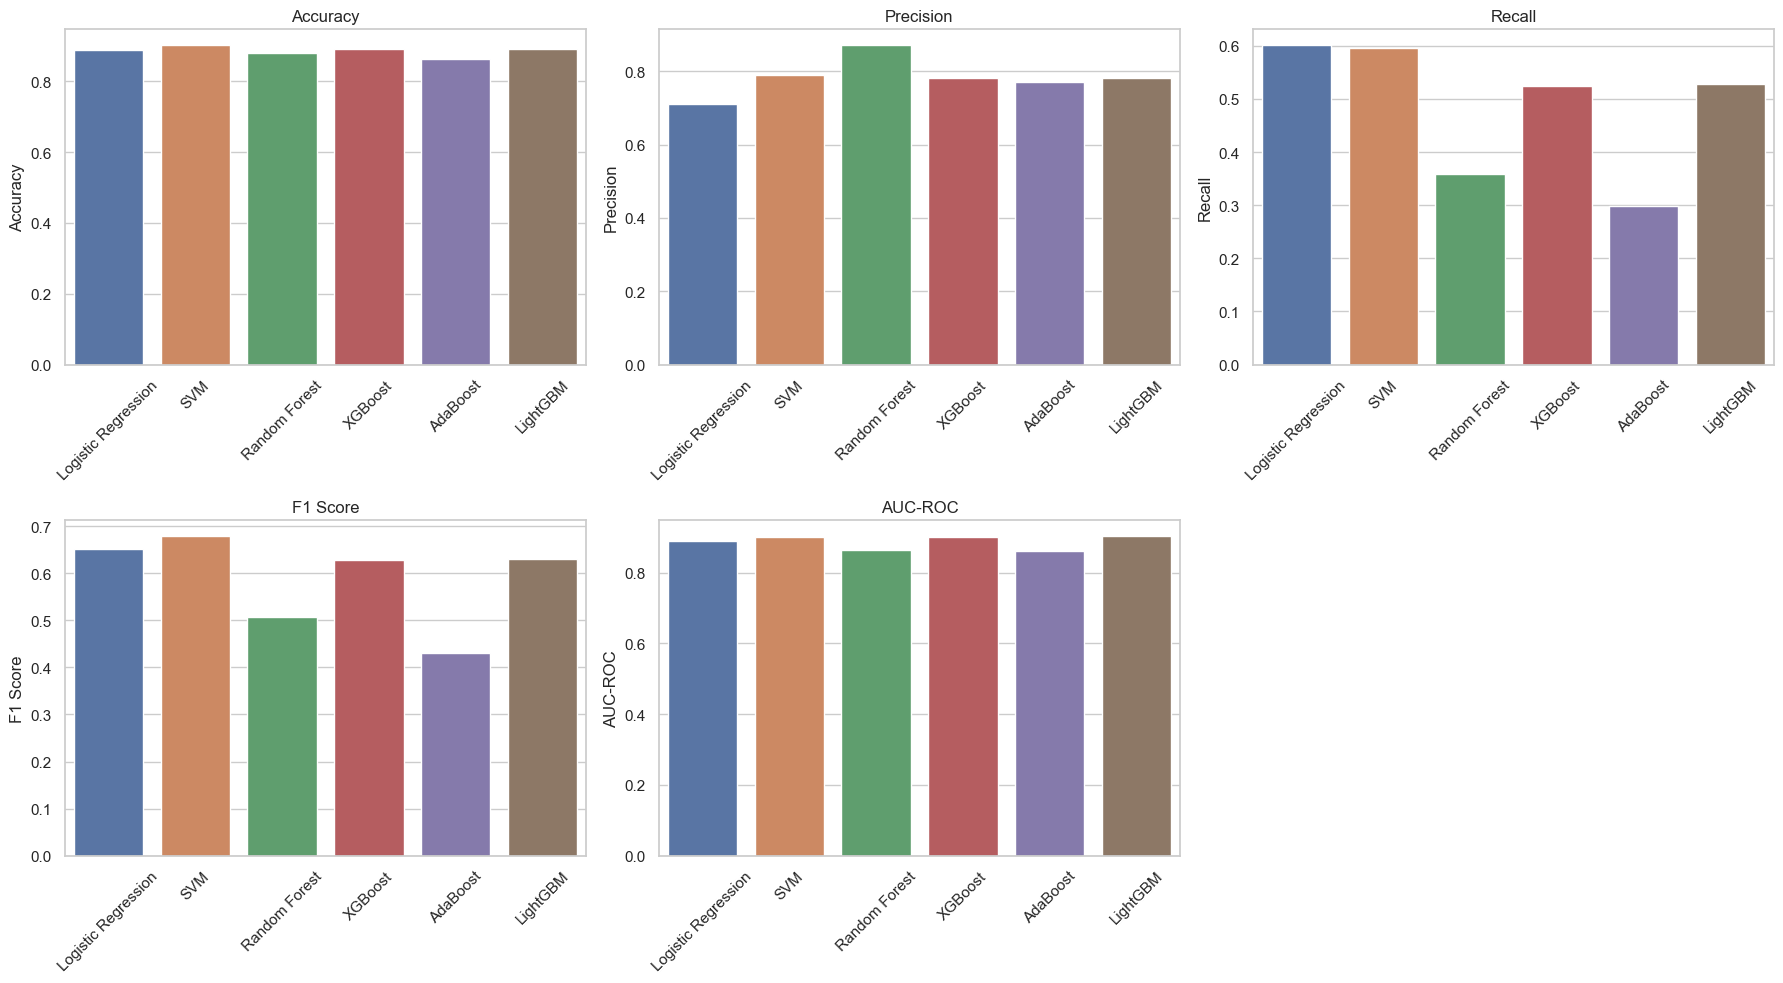

In [46]:
plot_metrics(tuned_metrics_df)